# Machine Learning Systems for Sleep Quality Assessment Based on EEG Signals

---

* **Author**: Carmen-Theodora Craciun
* **Status**: Done
* **The purpose of this Notebook**: This notebook handles *data cleaning, file verification, label mapping*, train/test/val splitting, and distribution analysis.
* **Dataset**: [Sleep-EDFX Database (PhysioNet)](https://www.physionet.org/content/sleep-edfx/1.0.0/)
  * **Studies used:**
    * Sleep Cassette (SC) - the study on healthy people
    * Sleep Telemetry (ST) - study on people diagnosed with mild insomnia.
* **Previos Step**: [Data visualization](https://colab.research.google.com/drive/1cBch3tvJHvTiagYhDABn147fa3gCt9Ud?usp=sharing)
* **Input**:
  * The 4 folders with the EDF files created in the step 1
  * full_paths.csv from step 2.
* **Output:**
  * class_distribution.csv
  * results.zip - a compressed archive containing the layered and prepared dataset for training (train, test, val)
    * each file in these folders represents a *processed sleep window* (epoch)

#Instalation and importing

In [ ]:
!pip install mne

In [ ]:
import os
import gc
import csv
import mne
import h5py
import json
import shutil
import logging
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from scipy.signal import resample
from sklearn.model_selection import train_test_split

mne.set_log_level('ERROR') # MNE will show only the errors
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

base_path = '/content/drive/MyDrive/sleep_data'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!rm -rf results
!mkdir -p results
!mkdir -p results/sleep_data_processed
!mkdir -p results/final_dataset

#Extract

In [ ]:
all_df = pd.read_csv(base_path + '/full_paths.csv')
print(f"The number of healthy results is: {len(all_df[all_df['study'] == 'SC (healthy)'])}")
print(f"The number of insomnia results is: {len(all_df[all_df['study'] == 'ST (insomnia)'])}")

The number of healthy results is: 153
The number of insomnia results is: 37


In [ ]:
all_df

,id,psg_path,hypno_path,study
0,SC4212,/content/drive/MyDrive/sleep_data/SC_healthy_p...,/content/drive/MyDrive/sleep_data/SC_healthy_h...,SC (healthy)
1,SC4542,/content/drive/MyDrive/sleep_data/SC_healthy_p...,/content/drive/MyDrive/sleep_data/SC_healthy_h...,SC (healthy)
2,SC4711,/content/drive/MyDrive/sleep_data/SC_healthy_p...,/content/drive/MyDrive/sleep_data/SC_healthy_h...,SC (healthy)
3,SC4122,/content/drive/MyDrive/sleep_data/SC_healthy_p...,/content/drive/MyDrive/sleep_data/SC_healthy_h...,SC (healthy)
4,SC4801,/content/drive/MyDrive/sleep_data/SC_healthy_p...,/content/drive/MyDrive/sleep_data/SC_healthy_h...,SC (healthy)
...,...,...,...,...
185,ST7022,/content/drive/MyDrive/sleep_data/ST_insomnia_...,/content/drive/MyDrive/sleep_data/ST_insomnia_...,ST (insomnia)
186,ST7052,/content/drive/MyDrive/sleep_data/ST_insomnia_...,/content/drive/MyDrive/sleep_data/ST_insomnia_...,ST (insomnia)
187,ST7051,/content/drive/MyDrive/sleep_data/ST_insomnia_...,/content/drive/MyDrive/sleep_data/ST_insomnia_...,ST (insomnia)
188,ST7222,/content/drive/MyDrive/sleep_data/ST_insomnia_...,/content/drive/MyDrive/sleep_data/ST_insomnia_...,ST (insomnia)


#Transform

##Quality checking

In [ ]:
class SleepDataQuality:
    def __init__(self, df):
        self.df = df.copy()

    def __check_hypno_quality(self, row):
        file_path = row['hypno_path']
        # Define the result structure, including N4 and hypno_error
        result = {
            'hypno_status': 'Unknown',
            'hypno_duration': 0,
            'n_epochs': 0,
            'W': 0, 'N1': 0, 'N2': 0, 'N3': 0, 'N4': 0, 'REM': 0, 'Unknown': 0,
            'hypno_error': ''  # New column for errors
        }

        # Updated mapping: Stage 4 -> N4
        stage_map = {
            'Sleep stage W': 'W', 'W': 'W',
            'Sleep stage 1': 'N1', '1': 'N1',
            'Sleep stage 2': 'N2', '2': 'N2',
            'Sleep stage 3': 'N3', '3': 'N3',
            'Sleep stage 4': 'N4', '4': 'N4',    # Explicitly map N4
            'Sleep stage R': 'REM', 'R': 'REM',
            'Movement time': 'Unknown', 'Sleep stage ?': 'Unknown'
        }

        # 1. Check physical existence
        if not os.path.exists(file_path):
             result['hypno_status'] = 'Missing_File'
             result['hypno_error'] = 'File path does not exist'
             return pd.Series(result)

        try:
            # 2. Read with MNE
            annot = mne.read_annotations(file_path)

            if len(annot) == 0 or annot.duration.sum() == 0:
                result['hypno_status'] = 'Empty_Annotations'
                result['hypno_error'] = 'File contains 0 annotations'
                return pd.Series(result)

            result['hypno_status'] = 'OK'
            result['hypno_duration'] = annot.duration.sum()

            for desc, dur in zip(annot.description, annot.duration):
                n_30s_chunks = int(dur // 30)
                stage = stage_map.get(desc, 'Unknown')

                if stage in result:
                    result[stage] += n_30s_chunks
                    result['n_epochs'] += n_30s_chunks

            return pd.Series(result)

        except Exception as e:
            # Capture the exact error from MNE
            result['hypno_status'] = 'Read_Error'
            result['hypno_error'] = str(e)

        # Fallback for 0-byte files that don’t raise exceptions but are empty
        try:
            if os.path.getsize(file_path) == 0:
                result['hypno_status'] = 'Empty_File_0B'
                result['hypno_error'] = 'File size is 0 bytes'
        except:
            pass

        return pd.Series(result)

    def __check_psg_quality(self, row):
        path = row['psg_path']
        result = {
            'psg_status': 'Unknown',
            'psg_duration': 0,
            'psg_ch_count': 0,
            'psg_error': ''
        }

        # Required channels
        required_channels = [
            'EEG Fpz-Cz',
            'EEG Pz-Oz',
            'EMG submental',
            'EOG horizontal'
        ]
        # Marker is checked separately (can be "Marker" or "Event marker")

        if not os.path.exists(path):
            result['psg_status'] = 'Missing_File'
            result['psg_error'] = 'File path does not exist'
            return pd.Series(result)

        try:
            # Read only the header
            raw = mne.io.read_raw_edf(path, preload=False, verbose=False)
            ch_names = raw.ch_names

            # Check required channels
            missing = []
            for req in required_channels:
                if req not in ch_names:
                    missing.append(req)

            # Check Marker (flexible)
            has_marker = any(m in ch_names for m in ['Marker', 'Event marker'])
            if not has_marker:
                missing.append('Marker')

            result['psg_duration'] = raw.times[-1]
            result['psg_ch_count'] = len(ch_names)

            if missing:
                result['psg_status'] = 'Missing_Channels'
                result['psg_error'] = f"Missing: {', '.join(missing)}"
            elif result['psg_duration'] < 3600:
                result['psg_status'] = 'Too_Short'
                result['psg_error'] = f"Duration {result['psg_duration']/3600:.1f}h < 1h"
            else:
                result['psg_status'] = 'OK'

        except Exception as e:
            result['psg_status'] = 'Read_Error'
            result['psg_error'] = str(e)

        return pd.Series(result)

    def _run_validation(self):
        """Run the complete process"""

        print("Checking Hypnograms")
        hypno_stats = self.df.apply(self.__check_hypno_quality, axis=1)
        print("Done checking the hypnograms\n")

        print("Checking PSG files")
        psg_stats = self.df.apply(self.__check_psg_quality, axis=1)
        print("Done checking the PSG files")

        final_df = pd.concat([self.df, hypno_stats, psg_stats], axis=1)
        self.__print_summary(final_df)
        return final_df

    def __print_summary(self, df):
        print("\n=== VALIDATION SUMMARY ===")
        print(f"Total Files: {len(df)}")
        print("The new dataframe looks like this:")
        display(df.head(1))

        print("\nErrors found:")
        error_hypno = df[((df['hypno_status'] != 'OK') |
                         (df['hypno_duration'] == 0)) |
                         (df['hypno_error'] != '')]
        if len(error_hypno):
            print("At hypnograms")
            display(error_hypno)
        else:
            print("No errors at hypnograms")

        error_psg = df[((df['psg_status'] != 'OK') |
                        (df['psg_duration'] == 0) |
                        (df['psg_error'] != '') )]
        if len(error_psg):
            print("At PSG files")
            display(error_psg)
        else:
            print("No errors at PSG files")


validator = SleepDataQuality(all_df)
validated_df = validator._run_validation()

# Deliting variabiles not used anymore
del all_df
del validator

Checking Hypnograms
Done checking the hypnograms

Checking PSG files
Done checking the PSG files

=== VALIDATION SUMMARY ===
Total Files: 190
The new dataframe looks like this:


,id,psg_path,hypno_path,study,hypno_status,hypno_duration,n_epochs,W,N1,N2,N3,N4,REM,Unknown,hypno_error,psg_status,psg_duration,psg_ch_count,psg_error
0,SC4212,/content/drive/MyDrive/sleep_data/SC_healthy_p...,/content/drive/MyDrive/sleep_data/SC_healthy_h...,SC (healthy),OK,86400.0,2880,2075,87,402,43,0,87,186,,OK,80819.99,7,



Errors found:
No errors at hypnograms
No errors at PSG files


In [ ]:
validated_df.drop(columns=['hypno_status', 'hypno_error','psg_status','psg_error'], inplace=True)
validated_df.head(5)

,id,psg_path,hypno_path,study,hypno_duration,n_epochs,W,N1,N2,N3,N4,REM,Unknown,psg_duration,psg_ch_count
0,SC4212,/content/drive/MyDrive/sleep_data/SC_healthy_p...,/content/drive/MyDrive/sleep_data/SC_healthy_h...,SC (healthy),86400.0,2880,2075,87,402,43,0,87,186,80819.99,7
1,SC4542,/content/drive/MyDrive/sleep_data/SC_healthy_p...,/content/drive/MyDrive/sleep_data/SC_healthy_h...,SC (healthy),86400.0,2880,1813,208,461,76,2,120,200,80399.99,7
2,SC4711,/content/drive/MyDrive/sleep_data/SC_healthy_p...,/content/drive/MyDrive/sleep_data/SC_healthy_h...,SC (healthy),86400.0,2880,1769,234,605,4,0,118,150,81899.99,7
3,SC4122,/content/drive/MyDrive/sleep_data/SC_healthy_p...,/content/drive/MyDrive/sleep_data/SC_healthy_h...,SC (healthy),86400.0,2880,1919,121,287,50,30,199,274,78179.99,7
4,SC4801,/content/drive/MyDrive/sleep_data/SC_healthy_p...,/content/drive/MyDrive/sleep_data/SC_healthy_h...,SC (healthy),86400.0,2880,1821,203,595,13,0,142,106,83219.99,7


##Label Mapping & Epoch Segmentation

In [ ]:
class LabelMapping:
    def __init__(self, output_dir='/content/results', sfreq=100, epoch_sec=30):
        self.output_dir = output_dir + '/sleep_data_processed'
        self.sfreq = sfreq
        self.epoch_sec = epoch_sec
        self.target_channels = ['EEG Fpz-Cz', 'EEG Pz-Oz']

    def __get_annotation_map(self):
        return {
            'Sleep stage W': 0,
            'Sleep stage 1': 1,
            'Sleep stage 2': 2,
            'Sleep stage 3': 3,  # N3
            'Sleep stage 4': 3,  # N4 becomes N3 (Standard AASM)
            'Sleep stage R': 4
        }

    def __load_and_clean_psg(self, psg_path):
        # 1. Load
        raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)

        # 2. Check channels
        if not all(ch in raw.ch_names for ch in self.target_channels):
            raise ValueError(f"Missing required channels. Found: {raw.ch_names}")

        # 3. Select channels
        raw.pick_channels(self.target_channels)

        # 4. Resampling (e.g., 100Hz)
        if raw.info['sfreq'] != self.sfreq:
            raw.resample(self.sfreq)

        # 5. Bandpass Filtering (0.3Hz - 35Hz)
        raw.filter(l_freq=0.3, h_freq=35.0, verbose=False)

        return raw

    def __extract_events(self, raw, hypno_path):
        annot = mne.read_annotations(hypno_path)
        raw.set_annotations(annot, emit_warning=False)

        mapping = self.__get_annotation_map()

        events, _ = mne.events_from_annotations(
            raw,
            event_id=mapping,
            chunk_duration=self.epoch_sec, # Split long stages
            verbose=False
        )
        return events, mapping

    def __create_epochs(self, raw, events, event_id):
        tmax = self.epoch_sec - 1. / raw.info['sfreq']

        epochs = mne.Epochs(
            raw,
            events,
            event_id=event_id,
            tmin=0., tmax=tmax,
            baseline=None,
            preload=True,
            verbose=False,
            on_missing='ignore' # Ignore stages that may be missing from a file
        )
        return epochs

    def __save_data(self, subject_id, epochs):
        # X: (n_epochs, n_channels, n_samples)
        # Multiply by 1e6 to convert to microvolts (easier for training models)
        X = epochs.get_data() * 1e6

        # y: (n_epochs,) - labels (0-4)
        y = epochs.events[:, 2]

        save_path = os.path.join(self.output_dir, f"{subject_id}.npz")
        np.savez_compressed(save_path, x=X, y=y)

        return X.shape, y.shape

    def __process_single_subject(self, row):
        subject_id = row['id']

        # Caching: If it already exists, skip
        if os.path.exists(os.path.join(self.output_dir, f"{subject_id}.npz")):
            return "Skipped (Exists)"

        try:
            # 1. Signal Processing
            raw = self.__load_and_clean_psg(row['psg_path'])

            # 2. Extract Events (Mapping)
            events, event_map = self.__extract_events(raw, row['hypno_path'])

            # 3. Windowing
            epochs = self.__create_epochs(raw, events, event_map)

            # 4. Save
            x_shape, y_shape = self.__save_data(subject_id, epochs)

            return f"Success {x_shape}"

        except Exception as e:
            return f"Error: {str(e)}"

    def run(self, df):
        # Filter only files previously marked as valid
        print("Start labeling")
        results = []

        for idx, row in tqdm(df.iterrows(), total=len(df)):
            status = self.__process_single_subject(row)
            results.append({'id': row['id'], 'etl_status': status})

            # Print errors immediately so we can see them
            if "Error" in status:
                print(f"Error: {row['id']}: {status}")

        print("\nPipeline Finished.")
        return pd.DataFrame(results)


label = LabelMapping()
label_results_df = label.run(validated_df)

print("Look for errors:")
label_results_df[~label_results_df['etl_status'].str.contains('Success')]

del label
del label_results_df

Start labeling


  0%|          | 0/190 [00:00<?, ?it/s]


Pipeline Finished.
Look for errors:


,id,etl_status


##Data distribution anlysis



We recall here the problem observed in the data visualization step:

> === COMPARISON HEALTHY (SC) vs INSOMNIA (ST) ===
>
> Duration:
>
> Healthy (SC): 153 files
>   * Mean: 22.68 h
>   * Min-Max: 17.00 - 24.00 h
>
> Insomnia (ST): 37 files
>   * Mean: 8.76 h
>   * Min-Max: 7.63 - 10.70 h
>
> Average difference: 13.92 h (Healthy (SC) - Insomnia (ST))

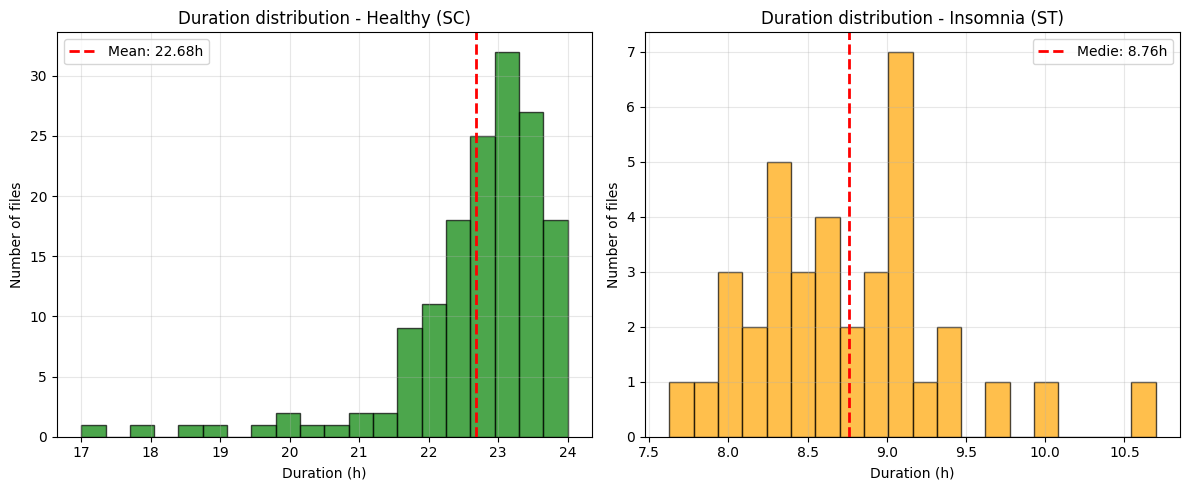

The SC study has too much recording time, automatically has too much Wake for our problem. We will have to cut out the moments when he is not actually sleeping.

Starting Smart Crop Job on 190 files...


  0%|          | 0/190 [00:00<?, ?it/s]

=== SUMMARY ===


  0%|          | 0/190 [00:00<?, ?it/s]


--- GLOBAL CLASS DISTRIBUTION ---
 Class ID Class Name  Count  Percentage
        0       Wake  39996   21.800343
        1         N1  20361   11.098030
        2         N2  76464   41.677704
        3         N3  17690    9.642166
        4        REM  28954   15.781757

Imbalance Ratio (Max/Min): 4.32:1
Status: ACCEPTABLE (Much better than before!)


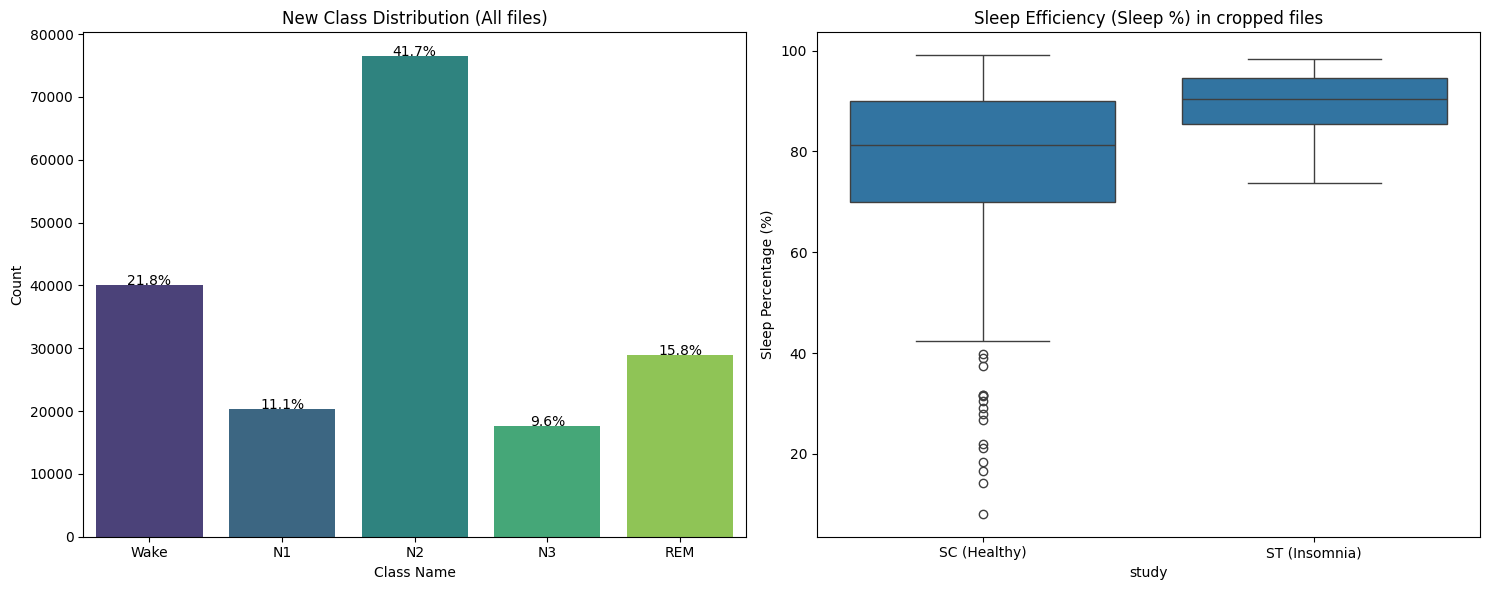

status
Cropped         153
Skipped (ST)     37
Name: count, dtype: int64
Number of files cropped is 0


In [ ]:
class SleepCropper:
    def __init__(self, data_dir='/content/results/sleep_data_processed', target_hours=8, sfreq=100):
        self.data_dir = data_dir
        self.target_hours = target_hours
        self.sfreq = sfreq
        self.epochs_for_target = int(target_hours * 3600 / 30) # e.g., 960 epochs for 8 hours

    def __find_sleep_onset(self, y_labels, min_consecutive=5):
        """
        Finds the index where sleep begins.
        Logic: The first sequence of 'min_consecutive' epochs that are NOT Wake (0).
        """
        consecutive_sleep = 0

        for i, label in enumerate(y_labels):
            if label != 0:  # 0 is Wake
                consecutive_sleep += 1
                if consecutive_sleep >= min_consecutive:
                    # Return the start index of the sequence
                    return max(0, i - min_consecutive + 1)
            else:
                consecutive_sleep = 0

        return 0 # Fallback: if no sleep is found, start from 0

    def __crop_file(self, file_path, study_type):
        """
        Load, crop, and save the file.
        """
        try:
            data = np.load(file_path)
            X = data['x']
            y = data['y']

            if study_type == 'SC (healthy)':

                # 1. Find Onset
                onset_idx = self.__find_sleep_onset(y)

                # 2. Calculate Offset (Onset + 8 hours)
                end_idx = onset_idx + self.epochs_for_target

                # Make sure not to exceed the total length
                if end_idx > len(y):
                    end_idx = len(y)

                # If the segment is too short (< 4 hours), it may be an error, but crop anyway

                # 3. Apply Crop
                X_cropped = X[onset_idx:end_idx]
                y_cropped = y[onset_idx:end_idx]

                # 4. Overwrite
                np.savez_compressed(file_path, x=X_cropped, y=y_cropped)

                return {
                    'status': 'Cropped',
                    'original_len': len(y),
                    'new_len': len(y_cropped),
                    'onset': onset_idx
                }

            else:
                return {'status': 'Skipped (ST)', 'new_len': len(y)}

        except Exception as e:
            return {'status': f'Error: {str(e)}'}

    def __verify_dataset_balance(self):
        print(f"=== SUMMARY ===")

        files = [f for f in os.listdir(self.data_dir) if f.endswith('.npz')]

        # Containers for statistics
        all_labels = []
        file_stats = []

        for filename in tqdm(files):
            try:
                filepath = os.path.join(self.data_dir, filename)
                data = np.load(filepath)
                y = data['y']

                # Collect all labels for the global distribution
                all_labels.extend(y)

                # Statistics per file
                unique, counts = np.unique(y, return_counts=True)
                dist = dict(zip(unique, counts))

                # Calculate "Sleep Efficiency" (approximate) for this segment
                # 0 = Wake. Everything else is sleep.
                total_epochs = len(y)
                wake_epochs = dist.get(0, 0)
                sleep_epochs = total_epochs - wake_epochs
                sleep_eff = (sleep_epochs / total_epochs) * 100 if total_epochs > 0 else 0

                study_type = 'SC (Healthy)' if 'SC' in filename else 'ST (Insomnia)'

                file_stats.append({
                    'filename': filename,
                    'study': study_type,
                    'total_epochs': total_epochs,
                    'wake_pct': (wake_epochs/total_epochs)*100,
                    'sleep_eff': sleep_eff
                })

            except Exception as e:
                print(f"Error at {filename}: {e}")

        # --- 1. Global Class Distribution ---
        print("\n--- GLOBAL CLASS DISTRIBUTION ---")
        unique_all, counts_all = np.unique(all_labels, return_counts=True)
        total_samples = len(all_labels)

        # Reverse mapping for clarity (0-4)
        class_names = {0: 'Wake', 1: 'N1', 2: 'N2', 3: 'N3', 4: 'REM'}

        stats_df = pd.DataFrame({
            'Class ID': unique_all,
            'Class Name': [class_names.get(i, 'Unknown') for i in unique_all],
            'Count': counts_all,
            'Percentage': (counts_all / total_samples) * 100
        })

        print(stats_df.to_string(index=False))

        # Check Imbalance Ratio
        max_cls = stats_df['Count'].max()
        min_cls = stats_df['Count'].min()
        ratio = max_cls / min_cls
        print(f"\nImbalance Ratio (Max/Min): {ratio:.2f}:1")
        if ratio < 10:
            print("Status: ACCEPTABLE (Much better than before!)")
        else:
            print("Status: Still imbalanced (Probably N1 is the minority class)")

        # --- 2. Visualization ---
        df_files = pd.DataFrame(file_stats)

        fig, axes = plt.subplots(1, 2, figsize=(15, 6))

        # Barplot Classes
        sns.barplot(data=stats_df, x='Class Name', y='Count', ax=axes[0], palette='viridis', hue='Class Name', legend=False)
        axes[0].set_title('New Class Distribution (All files)')
        for index, row in stats_df.iterrows():
            axes[0].text(index, row.Count, f'{row.Percentage:.1f}%', color='black', ha="center")

        # Boxplot Sleep Efficiency SC vs ST
        sns.boxplot(data=df_files, x='study', y='sleep_eff', ax=axes[1])
        axes[1].set_title('Sleep Efficiency (Sleep %) in cropped files')
        axes[1].set_ylabel('Sleep Percentage (%)')

        plt.tight_layout()
        plt.show()

        return stats_df

    def run(self, df):
        print(f"Starting Smart Crop Job on {len(df)} files...")
        results = []

        for idx, row in tqdm(df.iterrows(), total=len(df)):
            subject_id = row['id']
            study_type = row['study']

            file_path = os.path.join(self.data_dir, f"{subject_id}.npz")

            if os.path.exists(file_path):
                res = self.__crop_file(file_path, study_type)
                res['id'] = subject_id
                results.append(res)
            else:
                results.append({'id': subject_id, 'status': 'File Not Found'})

        stats_df = self.__verify_dataset_balance()
        return pd.DataFrame(results), stats_df

cropper = SleepCropper(target_hours=8)
crop_results, stats_df = cropper.run(validated_df)
print(crop_results['status'].value_counts())
print(f"Number of files cropped is {len(crop_results[(crop_results['original_len'] != crop_results['new_len']) & (crop_results['status'] == 'Cropped')])}")
stats_df.to_csv('/content/results/class_distribution.csv', index=False)
print(f"Saved results to: /content/results/class_distribution.csv")

del validated_df
del cropper
del crop_results
del stats_df

##Splitting

In [ ]:
class StratifiedDatasetSplitter:
    def __init__(self, source_dir='/content/results/sleep_data_processed', output_dir='/content/results/final_dataset', split_ratios=(0.70, 0.15, 0.15), seed=42):
        self.source_dir = source_dir
        self.output_dir = output_dir
        self.split_ratios = split_ratios # Train, Val, Test
        self.seed = seed
        self.subsets = ['train', 'val', 'test']

    def run(self):
        print(f"=== STRATIFIED DATASET SPLITTING ===")

        # 1. Identificăm fișierele
        all_files = [f for f in os.listdir(self.source_dir) if f.endswith('.npz')]

        # Le separăm manual pentru a garanta stratificarea
        sc_files = [f for f in all_files if 'SC' in f] # Healthy
        st_files = [f for f in all_files if 'ST' in f] # Insomnia

        print(f"Total Files Found: {len(all_files)}")
        print(f"  - Healthy (SC): {len(sc_files)} files")
        print(f"  - Insomnia (ST): {len(st_files)} files")

        # 2. Funcție de split pentru o listă specifică
        def split_list(file_list):
            if not file_list: return [], [], []

            # Calculăm mărimile
            train_r, val_r, test_r = self.split_ratios

            # Split 1: Train vs (Val+Test)
            test_val_size = val_r + test_r
            train, temp = train_test_split(file_list, test_size=test_val_size, random_state=self.seed, shuffle=True)

            # Split 2: Val vs Test
            relative_test_size = test_r / test_val_size
            val, test = train_test_split(temp, test_size=relative_test_size, random_state=self.seed, shuffle=True)

            return train, val, test

        # 3. Executăm split-ul separat
        sc_train, sc_val, sc_test = split_list(sc_files)
        st_train, st_val, st_test = split_list(st_files)

        # 4. Raportare distribuție
        print("\n--- Distribution Report ---")
        print(f"TRAIN: {len(sc_train)} Healthy + {len(st_train)} Insomnia = {len(sc_train)+len(st_train)} files")
        print(f"VAL:   {len(sc_val)} Healthy + {len(st_val)} Insomnia  = {len(sc_val)+len(st_val)} files")
        print(f"TEST:  {len(sc_test)} Healthy + {len(st_test)} Insomnia = {len(sc_test)+len(st_test)} files")

        # 5. Mutarea fizică a fișierelor
        print("\nMoving files...")

        splits = {
            'train': sc_train + st_train,
            'val':   sc_val + st_val,
            'test':  sc_test + st_test
        }

        for subset_name, files in splits.items():
            target_path = os.path.join(self.output_dir, subset_name)
            os.makedirs(target_path, exist_ok=True)

            for filename in files:
                src = os.path.join(self.source_dir, filename)
                dst = os.path.join(target_path, filename)
                shutil.copy2(src, dst)

        print(f"Done! Data is ready in: {self.output_dir}")

splitter = StratifiedDatasetSplitter()
splitter.run()

del splitter

=== STRATIFIED DATASET SPLITTING ===
Total Files Found: 190
  - Healthy (SC): 153 files
  - Insomnia (ST): 37 files

--- Distribution Report ---
TRAIN: 107 Healthy + 25 Insomnia = 132 files
VAL:   23 Healthy + 6 Insomnia  = 29 files
TEST:  23 Healthy + 6 Insomnia = 29 files

Moving files...
Done! Data is ready in: /content/results/final_dataset


#Load

In [ ]:
!cd /content/results/final_dataset
!zip -r /content/process_data.zip train test val

files.download('/content/process_data.zip')

  adding: content/results/final_dataset/ (stored 0%)
  adding: content/results/final_dataset/val/ (stored 0%)
  adding: content/results/final_dataset/val/SC4631.npz (deflated 0%)
  adding: content/results/final_dataset/val/SC4232.npz (deflated 0%)
  adding: content/results/final_dataset/val/SC4771.npz (deflated 0%)
  adding: content/results/final_dataset/val/SC4732.npz (deflated 0%)
  adding: content/results/final_dataset/val/ST7221.npz (deflated 0%)
  adding: content/results/final_dataset/val/SC4411.npz (deflated 0%)
  adding: content/results/final_dataset/val/SC4012.npz (deflated 0%)
  adding: content/results/final_dataset/val/SC4252.npz (deflated 0%)
  adding: content/results/final_dataset/val/SC4652.npz (deflated 0%)
  adding: content/results/final_dataset/val/SC4762.npz (deflated 0%)
  adding: content/results/final_dataset/val/SC4312.npz (deflated 0%)
  adding: content/results/final_dataset/val/SC4341.npz (deflated 0%)
  adding: content/results/final_dataset/val/SC4671.npz (deflat

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

---
# Conclusions and Next Step

In this notebook we:
1. Extract / **Data Ingestion.** - the process of reading raw files to access to all raw files in an indexed format, without altering their content.

2. Transform
* **Quality Checking**
  * **Technical Cleanup.** - identification of files that are impossible to use for technical reasons.
  * Resulting in a "clean" list, removing corrupt files, empty files or those that do not contain valid sleep annotations, to prevent errors in the next steps.

* **Label Mapping & Epoch Segmentation**
  * Translation of old labels to the modern AASM standard (W, N1, N2, N3, REM).
  * Cutting the continuous signal and hypnograms into fixed time windows in 30 seconds.
  * To transform the variable raw data into a uniform matrix of epochs with numerical labels, ready to enter a neural model.

* **Data Distribution Analysis**
  * *Understanding Imbalances.* Statistical analysis of sleep classes.
  * To visualize how often each stage occurs (e.g. W is often majority, N1 is very rare). This dictates the training strategy (whether you need *Class Weights* or *Oversampling* to avoid ignoring rare classes).

* **Splitting**
  * *Separate Data for Validation.*
  * To ensure an honest evaluation of the model.
  * Splitting was be done **per patient (Subject-level split)**, not per epoch. That is, the epochs of patient X are not allowed to be both training and testing, to avoid *Data Leakage*.

3. Load - Saved the results for further use.

The next step in the project is to start building the model architectures. We will start with a baseline standard, [**Simple 1D-CNN**]().